Query NASA/Ads from python

https://github.com/adsabs/adsabs-dev-api/blob/master/README.md

In [1]:
from astroquery.ned import Ned
from astroquery.nasa_ads import ADS
ADS.TOKEN = open('ADS_DEV_KEY','r').read()
token = open('ADS_DEV_KEY','r').read()
import requests
import urllib
import json

In [2]:
from pymuse.constants import tab10

In [3]:
result_table = Ned.get_table("NGC628", table='positions')

result_table

No.,RA,DEC,Frequency,Uncertainty Ellipse Semi-Major Axis,Uncertainty Ellipse Semi-Minor Axis,Uncertainty Ellipse PA,Refcode,Published Name,Published RA,Published Dec,Published RA Uncertainty,Published Dec Uncertainty,Published PA Uncertainty,Uncertainty Significance,Published Equinox,Published Epoch,NED Frequency,Published System Coordinate,Published Unit,Published Frame,Published Frequence Mode,Qualifiers
,,,,arcsec,arcsec,,,,,,,,,,,,Hz,,,,,
int32,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object
0,01h36m41.747s,+15d47m01.18s,,0.32,0.32,0,2010ApJS..189...37E,,,,,,,,,,--,,,,,
1,01h36m41.8000s,+15d47m01.000s,,--,--,,2014ApJS..212...18B,NGC 0628,013641.8,+154701.,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
2,01h36m41.8000s,+15d47m17.000s,,--,--,,2014MNRAS.439.2542G,NGC 0628,013641.8,+154717.,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
3,01h36m41.7600s,+15d47m00.000s,,--,--,,2014MNRAS.441.3570G,Messier 074,013641.76,+154700.0,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
4,01h36m41.7000s,+15d47m01.000s,,--,--,,2014PASJ...66...66T,MESSIER 074,013641.7,+154701.00,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
5,01h36m41.7600s,+15d47m00.384s,,--,--,,2011MNRAS.412.1419L,,013641.7600,+154700.384,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
6,01h36m41.8099s,+15d47m00.301s,,--,--,,2014MNRAS.442.3711G,,013641.81,+154700.3,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
7,01h36m41.7000s,+15d47m01.000s,,--,--,,2014MNRAS.443..186H,,013641.7,+154701.,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin


In [5]:
def check_type(func):
    def inner(x,y):
        print()


@check_type
def add(x,y):
    return x+y


add(1,"2")


TypeError: 'NoneType' object is not callable

In [14]:
query = 'id:2019ApJ...887...80K'
query = urllib.parse.quote(query)

start=0
cache_rows=200
sort='pubdate+desc'

r = requests.get('https://api.adsabs.harvard.edu/v1/search/query?'
              f'q={query}&start={start}&rows={cache_rows}'
               f'&sort={sort}&fl=title,author,year,bibcode,pub',
               headers={'Authorization': f'Bearer {token}'})
    
resp = r.json()  


In [66]:
def get_bibtex(bibcodes):
    '''retrive the bibtex entry from ads
    
    '''
    
    if not isinstance(bibcodes,list):
        bibcodes = [bibcodes]
        
    bibcode = {"bibcode":bibcodes}
    r = requests.post("https://api.adsabs.harvard.edu/v1/export/bibtex", \
                     headers={"Authorization": "Bearer " + token, "Content-type": "application/json"}, \
                     data=json.dumps(bibcode))
    
    # in case of an error
    if not r.ok:
        if r.status_code == 401:
            raise ValueError('Unauthorized access to ADS. Check that the ADS token is valid.')
        try:
            reason = r.json()['error']
        except:
            reason = r.text
        raise ValueError(f'HTTP request failed ({r.status_code}): {reason}')
    
    return r.json()['export']

bib = get_bibtex(['2019ApJ...887...80K'])

In [53]:
r = requests.get("https://api.adsabs.harvard.edu/v1/search/query?q='references(id:2019ApJ...887...80K)'",\
                headers={'Authorization': 'Bearer ' + token})
# the requests package returns an object; to get just the JSON API response, you have to specify this
#print(r.json())
r.ok

False

https://github.com/andycasey/ads

In [54]:
import ads

In [55]:
ads.config.token = open('ADS_DEV_KEY','r').read()

In [70]:
bibcode = '2019ApJ...887...80K'

In [73]:
ads.SearchQuery?

In [74]:
list(ads.SearchQuery(bibcode=bibcode))

In [59]:
articles = [list(ads.SearchQuery(bibcode=bibcode))[0] for bibcode in bibcodes]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

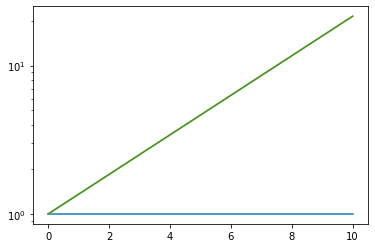

In [10]:
x = np.linspace(0,10)

y1 = (1-np.exp(3*(-4.47-x)))
y2 = np.exp(0.307*x)

y = y1*y2
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y)

plt.yscale('log')

In [32]:
from astropy.io import fits
from pathlib import Path
import logging
from astropy.wcs import WCS

In [34]:
from reproject import reproject_interp, reproject_exact


z = 0.0028906664

def combine_fits(folder,output_projection):
    '''combine the different linemaps into one fits file
    
    
    '''
    
    if not folder.is_dir():
        raise IOError('folder does not exist')

    data = []
    data_header = []
    err  = []
    err_header = []
    
    # so astropy doesn't warn us that the wcs contains unused sip information
    logger = logging.getLogger('astropy')
    logger.setLevel(logging.WARNING)  
    
    for flux_file in [x for x in (folder / 'MAPS').iterdir() if x.name.endswith('flux.fits')]:
        err_file = flux_file.with_name(flux_file.stem + '-err.fits')
        
        with fits.open(flux_file) as hdul:
            linemap, _ = reproject_exact(hdul, output_projection)
            data.append(linemap)
            data_header.append(hdul[0].header)
            
        with fits.open(err_file) as hdul:
            linemap, _ = reproject_exact(hdul, output_projection)
            err.append(linemap)
            err_header.append(hdul[0].header)         
         
    object_name = str(folder).split('_')[0]
    print(str(len(data)) + ' linemaps found for ' + object_name)

    
    keywords = ['PROGRAM','DATE','OBSERVAT','TELESCOP','INSTRUME','MJD-OBS','DATE-OBS']

    primary_header = fits.Header()
    for card in data_header[0].cards:
        if card[0] in keywords:
            primary_header.append(card)
    
    l = float(data_header[0]['FILETYPE'].split(' ')[-1])/(1+z)
    
    # get this from somewhere else
    primary_header.insert('PROGRAM ',('OBJECT',object_name,'Object Name'))
        
    primary_hdu = fits.PrimaryHDU(header=primary_header)
    hdul = fits.HDUList([primary_hdu]) 
    print('primary extension created')
    
    for d,dh,e,eh in zip(data,data_header,err,err_header):
        
        # get the original wavelength of the line
        l = float(dh['FILETYPE'].split(' ')[-1])/(1+z)
        header = WCS(output_projection).to_header()
        header['BITPIX'] = (-32,'array data type')
        header.insert(0,('FILETYPE','Map flux {:.0f}'.format(l)))
        header.append()
        
        hdu = fits.ImageHDU(data=d,header=header,name='OII{:.0f}'.format(l))
        hdul.append(hdu)
        
        header['FILETYPE'] = 'Map flux error {:.0f}'.format(l)
        hdu = fits.ImageHDU(data=e,header=header,name='OII{:.0f}_err'.format(l))
        hdul.append(hdu)
        
        #single = fits.PrimaryHDU(d)
        #single.writeto('[OII]{:.0f}.fits'.format(l))
        
    print('all extensions created')
    
    filename = '{}_[OII]_maps.fits'.format(object_name)
    hdul.writeto(filename,overwrite=True)
    print('saved to {}'.format(filename))
    
    return hdul


folder = Path('d:/Documents/university/PhD/sitelle/NGC2835_SN1.1.0.ORCS')
data_raw = Path('d:\downloads\MUSEDAP')
muse_header = fits.getheader(data_raw/'MUSEDAP'/'NGC2835_MAPS.fits',ext=1)

#combine_fits(Path('NGC2835_SN1.1.0.ORCS'),muse_header)
hdul = combine_fits(folder,muse_header)


2 linemaps found for d:\Documents\university\PhD\sitelle\NGC2835
primary extension created
all extensions created
saved to d:\Documents\university\PhD\sitelle\NGC2835_[OII]_maps.fits


## masks to contours

In [ ]:
from skimage import measure
from skimage.draw import polygon
from collections import Counter
import numpy as np

from astropy import wcs
from astropy.io import fits

import matplotlib.pyplot as plt

In [252]:
from astropy.io import fits
from pathlib import Path

data_raw = Path('g:\Archive')

mask_file = data_raw/'MUSE'/'DR1'/'AUXILIARY'/'Nebulae catalogue'/'spatial_masks'/'NGC2835_HIIreg_mask.fits' 
with fits.open(mask_file) as hdul:
    mask = hdul[0].data
    mask_header = hdul[0].header

basedir = Path('d:\Documents') / 'university' / 'PhD' / 'sitelle'
with fits.open(basedir/'NGC2835_deepframe.fits') as hdul:
    target_data = hdul[0].data
    target_header = hdul[0].header

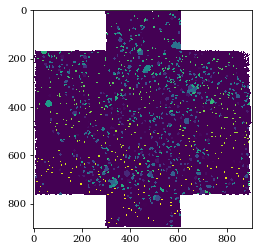

In [137]:
plt.imshow(mask)
plt.savefig('test.pdf')


In [73]:
props = measure.regionprops(mask.astype(int))

In [104]:
def reverse_columns(array):
    """This function reverses the order of the columns
    
    old: 
    temp = coordinates[:,0]
    temp2 = coordinates[:,1]

    return np.column_stack([temp2, temp])

    new:
    faster because we do not create two new arrays
    also works with shapes other than (n,2)

    Parameters
    ----------
    array : ndarray
    """

    return array.T[::-1].T

In [ ]:
from pymuse.masks_to_contours import get_contours, \
                                     convert_pixel2world,convert_world2pixel,\
                                     create_masks_from_wcs_contours

###
# at 0.5, contours will perfectly line up with mask boundaries, so
# in current wcs projection use 0.5. But at 0, boundaries as inflated (dilated)
# slightly by half a pixel, which, will not plot nice for touching masks
# (as not the contours will overlap a little), but might help masking
# new wcs projections which have bigger pixels. I recommend just using 0.5
contour_dilation = 0.5

contours_y_x,  contour_id = get_contours(labeled_image=mask,
                                         contour_dilation=contour_dilation,
                                         get_contour_id=True,
                                         touching_masks=False) #if masks do not touch, change this to False

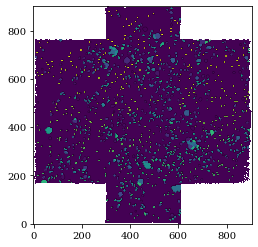

In [139]:
plt.figure(1)
plt.imshow(mask, origin='lower')
for cont in contours_y_x:
    plt.plot(cont[:,1]+1, cont[:,0]+1, 'k-',lw=0.2) #to make lines look thinner, set lw=0.8 in plt.plot
    
plt.savefig('test.pdf')
plt.show()

In [113]:
mask

In [231]:

    
print(f'{len(touching)} touching regions found')

180 touching regions found


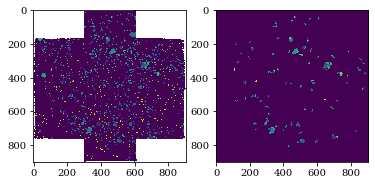

In [232]:
fig,(ax1,ax2) =plt.subplots(1,2)

ax1.imshow(mask)

im = ax2.imshow(touching_regions)
plt.savefig('test.pdf',dpi=800)

plt.show()


In [312]:
from astropy.wcs import WCS
from skimage.measure import regionprops, find_contours

class regions:
    
    def __init__(self,data,header=None):
        '''
        
        Parameters
        ----------
        data : ndarray 
            array with labeld regions
        header : 
        '''
        
        self.data = data
        self.header = header
        self.wcs = WCS(header)
        
        self.regions = {reg.label: reg for reg in regionprops(self.data.astype(int))}
        
        with np.errstate(invalid='ignore'):
            self.regions_id = set(np.unique(mask[mask>=0]).flatten())
        

        
    def find_touching(self,bkg=0):
        '''find all regions that touch another region'''
    
        touching = set()

        # for each row up to the second last one we subtract the row below
        difference = np.zeros_like(self.data)
        difference[:-1,...] = self.data[:-1,...] - self.data[1:,...]
        difference[self.data==bkg] = 0
        difference[difference==self.data+bkg] = 0
        touching |= set(self.data[(difference!=0) & ~np.isnan(difference)])

        # now going the other way around
        difference = np.zeros_like(self.data)
        difference[1:,...] = self.data[1:,...] - self.data[:-1,...]
        difference[self.data==-bkg] = 0
        difference[difference==self.data+bkg] = 0
        touching |= set(self.data[(difference!=0) & ~np.isnan(difference)])
        
        # left to right
        difference = np.zeros_like(self.data)
        difference[...,1:] = self.data[...,1:] - self.data[...,:-1]
        difference[self.data==-bkg] = 0
        difference[difference==self.data+bkg] = 0
        touching |= set(self.data[(difference!=0) & ~np.isnan(difference)])

        # right to left
        difference = np.zeros_like(self.data)
        difference[...,:-1] = self.data[...,:-1] - self.data[...,1:]
        difference[self.data==-bkg] = 0
        difference[difference==self.data+bkg] = 0
        touching |= set(self.data[(difference!=0) & ~np.isnan(difference)])
        
        return touching

    def select_regions(self,regions_id):
        '''create an image that contains only the regions in region_id'''
        
        if not isinstance(regions_id,list): regions_id = list(regions_id)
            
        data = np.zeros_like(self.data)

        for i in regions_id:
            data[self.data==i] = i
        data[np.isnan(self.data)] = np.nan
        
        return data
    
    def construct_separated_regions(self):
        '''
        
        '''
        
        # the regions that touch another region will be handled later
        remaining = self.find_touching()
        
        batches = []
        
        batches.append(self.select_regions(self.regions_id-remaining))
        
        while len
        
        
    
    
    def plot_regions(self,regions_id,filename=None):
        
        data = self.select_regions(regions_id)

        fig = plt.figure()
        ax  = fig.add_subplot(111,projection=self.wcs)
        ax.imshow(data)

        if filename:
            plt.savefig(filename,dpi=800)
        plt.show()
        
region = regions(mask+1,mask_header)

In [326]:

mask.shape

(901, 904)

In [334]:
l = int(np.ceil(max([v.major_axis_length for k,v in region.regions.items()])))
x_n = int(np.ceil(mask.shape[0]/l))
y_n = int(np.ceil(mask.shape[1]/l))

In [335]:
masked_list = []
for n in range(x_n):
    for m in range(y_n):
        
        masked_region = np.zeros_like(mask)
        
        masked_region[n*l:(n+1)*l,m*l:(m+1)*l] = 1
        
        masked_list.append(masked_region)

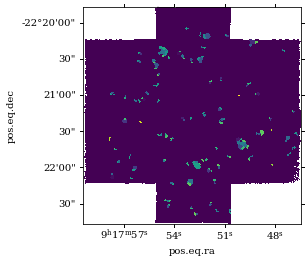

In [306]:
touching = region.find_touching()
region.plot_regions(touching)

In [314]:
len(region.regions_id-touching)

902

In [142]:
level=0.5
contours = []
for region_id in regions_id:
    array = np.zeros_like(mask)
    array[mask==region_id] = 1
    
    contour = measure.find_contours(array,level)
    contours += contour

In [199]:
touching.update([1,2,3,3,4])

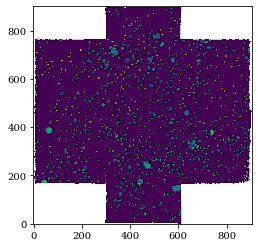

In [145]:
plt.figure(1)
plt.imshow(mask, origin='lower')
for cont in contours:
    plt.plot(cont[:,1]+1, cont[:,0]+1, 'k-',lw=0.2) #to make lines look thinner, set lw=0.8 in plt.plot
    
plt.savefig('test.pdf')
plt.show()

d:\documents\university\phd\pymuse\src\pymuse\masks_to_contours.py:102: RuntimeWarning: invalid value encountered in greater
  most_common = most_common[most_common>0]


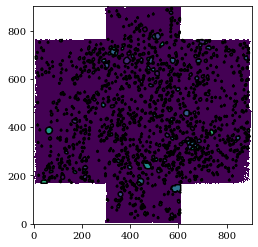

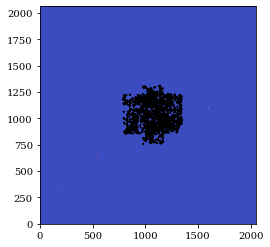

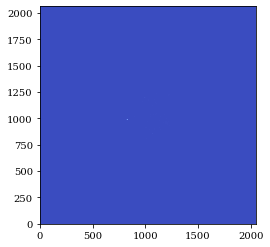

In [31]:
#boundaries saved as wsc so can be loaded into whatever wcs projection you want
contours_WCS = []
for j in range(len(contours_y_x)):
    contour_x_y = reverse_columns(contours_y_x[j])
    contours_WCS.append(convert_pixel2world(contour_x_y, galaxy_header))


contours_x_y_new = []
for j in range(len(contours_WCS)):
    contours_x_y_new.append(convert_world2pixel(contours_WCS[j],
                                                different_galaxy_wcs_header))


plt.figure(2)
plt.clf()
plt.imshow(different_galaxy_wcs, origin='lower', cmap=plt.cm.coolwarm)
for cont in contours_x_y_new:
    plt.plot(cont[:,0], cont[:,1], 'k-')

masks_new_wcs = create_masks_from_wcs_contours(contours_WCS=contours_WCS,
                                              contourIDs=contour_id,
                                              header=different_galaxy_wcs_header,
                                              image=different_galaxy_wcs,
                                              binary_mask_out=False)

# just rerunning this to show that I only want binary mask out
masks_new_wcs_binary = create_masks_from_wcs_contours(contours_WCS=contours_WCS,
                                                      contourIDs=contour_id,
                                                      header=different_galaxy_wcs_header,
                                                      image=different_galaxy_wcs,
                                                      binary_mask_out=True)

plt.figure(3)
plt.imshow(masks_new_wcs_binary * different_galaxy_wcs, origin='lower', cmap=plt.cm.coolwarm)

## Sankey

In [6]:
# -*- coding: utf-8 -*-
"""
Produces simple Sankey Diagrams with matplotlib.
@author: Anneya Golob & marcomanz & pierre-sassoulas & jorwoods
                      .-.
                 .--.(   ).--.
      <-.  .-.-.(.->          )_  .--.
       `-`(     )-'             `)    )
         (o  o  )                `)`-'
        (      )                ,)
        ( ()  )                 )
         `---"\    ,    ,    ,/`
               `--' `--' `--'
                |  |   |   |
                |  |   |   |
                '  |   '   |
https://github.com/anazalea/pySankey
"""

from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tab10 = ['#e15759','#4e79a7','#f28e2b','#76b7b2','#59a14e','#edc949','#b07aa2','#ff9da7','#9c755f','#bab0ac']   

class PySankeyException(Exception):
    pass


class NullsInFrame(PySankeyException):
    pass


class LabelMismatch(PySankeyException):
    pass


def check_data_matches_labels(labels, data, side):
    if len(labels > 0):
        if isinstance(data, list):
            data = set(data)
        if isinstance(data, pd.Series):
            data = set(data.unique().tolist())
        if isinstance(labels, list):
            labels = set(labels)
        if labels != data:
            msg = "\n"
            if len(labels) <= 20:
                msg = "Labels: " + ",".join(labels) + "\n"
            if len(data) < 20:
                msg += "Data: " + ",".join(data)
            raise LabelMismatch('{0} labels and data do not match.{1}'.format(side, msg))


def sankey(left, right, leftWeight=None, rightWeight=None, colorDict=None,
           leftLabels=None, rightLabels=None, aspect=4, rightColor=False,
           fontsize=14, filename=None, closePlot=False):
    '''
    Make Sankey Diagram showing flow from left-->right
    Inputs:
        left = NumPy array of object labels on the left of the diagram
        right = NumPy array of corresponding labels on the right of the diagram
            len(right) == len(left)
        leftWeight = NumPy array of weights for each strip starting from the
            left of the diagram, if not specified 1 is assigned
        rightWeight = NumPy array of weights for each strip starting from the
            right of the diagram, if not specified the corresponding leftWeight
            is assigned
        colorDict = Dictionary of colors to use for each label
            {'label':'color'}
        leftLabels = order of the left labels in the diagram
        rightLabels = order of the right labels in the diagram
        aspect = vertical extent of the diagram in units of horizontal extent
        rightColor = If true, each strip in the diagram will be be colored
                    according to its left label
    Ouput:
        None
    '''
    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['left'], 'left')

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        for i, label in enumerate(allLabels):
            colorDict[label] = tab10[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    for i, leftLabel in enumerate(leftLabels):
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(8, 6)
    plt.show()
    if filename != None:
        plt.savefig(filename, bbox_inches='tight', dpi=600)
    if closePlot:
        plt.close()

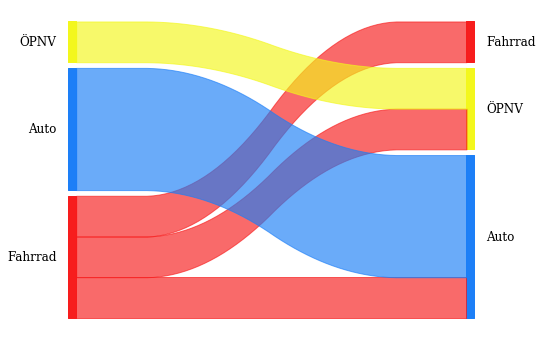

In [7]:
a = ['Fahrrad','Fahrrad','Auto','Auto','ÖPNV','Auto','Fahrrad']
b = ['Auto','ÖPNV','Auto','Auto','ÖPNV','Auto','Fahrrad']

colorDict = {
    'Fahrrad':'#f71b1b',
    'Auto':'#1b7ef7',
    'ÖPNV':'#f3f71b',
    'lime':'#12e23f',
    'orange':'#f78c1b'
}

sankey(a,b, aspect=20, colorDict=colorDict,fontsize=12)